#### Set experiment parameters in config
For training that terminates in a reasonable timeframe use data in sample_subset/audio.
This is not a real dataset as it consists of 10 images, but the functionality of the code can be examined.
The full dataset can be found here "https://magenta.withgoogle.com/datasets/nsynth#files" It must first be extracted, for example with the function in data_work.ipynb. To use the full dataset, preprocessing is recommend. A function for this purpose can also be found in the data_work notebook. To continue with the experiment, set the parameters of the config to something reasonable for your hardware like done bewlow:

In [1]:
import sys
import os
from pathlib import Path
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(''))))

notebook_dir = Path.cwd()  # Current working directory when notebook is run
project_root = notebook_dir.parent if notebook_dir.name == 'core' else notebook_dir
sys.path.insert(0, str(project_root))
from core.config import load_config
config = load_config()
config.vae.batch_size = 32
config.vae.epochs = 100

In [ ]:
from core.train_vae import train, test, simple_kl_annealing
from core.datasets import HDF5SpectrogramDataset, collate_fn
from core.VAE_models import VAE, CVAE, CVAE_Deep, count_parameters, save_checkpoint

from datetime import datetime


from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import v2
import torch

conv = True

# Define image transformation if wanted for regularization
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(128, 172), antialias=True),
    v2.RandomHorizontalFlip(p=0.5)
    ])


train_data = HDF5SpectrogramDataset(project_root / 'data' / 'train_spectrograms_even.h5', transform=transforms)
test_data = HDF5SpectrogramDataset(project_root / 'data' / 'valid_spectrograms_even.h5')

train_loader = DataLoader(train_data, batch_size=config.vae.batch_size, shuffle=True, pin_memory=True, num_workers=8, persistent_workers=True, prefetch_factor=2)
test_loader = DataLoader(test_data, batch_size=config.vae.batch_size, shuffle=False, pin_memory=True, num_workers=4, persistent_workers=True)

sample_spec = train_data[0] # Sample spectogram 
in_dim = sample_spec.numel() # For spectograms = width * height
image_size = tuple(sample_spec.size())

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join(config.log_dir, timestamp)
os.makedirs(log_dir, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

if conv:
    model = CVAE_Deep([128, 172], config.vae.latent_dim, 0.0).to(device)
else:
    model = VAE(in_dim, config.vae.latent_dim, config.vae.n_layers, config.vae.beta_kl).to(device)

print(count_parameters(model))

torch.set_float32_matmul_precision("medium")

optimizer = torch.optim.Adam(model.parameters(), lr=config.vae.lr, weight_decay=config.vae.weight_decay, decoupled_weight_decay=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.vae.epochs)
writer = SummaryWriter(log_dir)
prev_updates = 0
best_loss = torch.tensor(float('Inf'))
for epoch in range(config.vae.epochs):
    print(f'Epoch {epoch+1}/{config.vae.epochs}')
    beta = simple_kl_annealing(epoch, config.vae.epochs)
    print(f'using beta: {beta}')
    model.set_beta(beta)
    prev_updates = train(model, train_loader, optimizer, prev_updates, config, device=device, writer=writer, conv=conv)
    scheduler.step()
    test_loss, test_recon_loss, test_kl_loss = test(model, test_loader, prev_updates, config, device, writer=writer, conv=True)
    if test_recon_loss < best_loss:
        best_loss = test_recon_loss
        if conv:
            save_checkpoint(model, optimizer, epoch, test_kl_loss, config, image_size)
        else:
            save_checkpoint(model, optimizer, epoch, test_kl_loss, config, in_dim)
    


cuda
37826017
Epoch 1/100
using beta: 0.01


  0%|          | 3/9038 [00:01<57:46,  2.61it/s]  

Step 0 (N samples: 0), Loss: 11288.0605 (Recon: 11287.8359, KL: 0.2243) Grad: 43942.4905


  6%|▌         | 504/9038 [00:32<08:01, 17.73it/s]

Step 500 (N samples: 16,000), Loss: 640.4179 (Recon: 628.2997, KL: 12.1182) Grad: 2098.6950


 11%|█         | 1004/9038 [01:01<08:01, 16.68it/s]

Step 1,000 (N samples: 32,000), Loss: 727.5848 (Recon: 714.4274, KL: 13.1575) Grad: 4907.1972


 17%|█▋        | 1504/9038 [01:30<07:34, 16.58it/s]

Step 1,500 (N samples: 48,000), Loss: 678.5701 (Recon: 665.1703, KL: 13.3997) Grad: 11284.2798


 22%|██▏       | 2004/9038 [01:59<06:54, 16.98it/s]

Step 2,000 (N samples: 64,000), Loss: 496.3785 (Recon: 485.2839, KL: 11.0946) Grad: 2894.9735


 28%|██▊       | 2504/9038 [02:28<06:47, 16.04it/s]

Step 2,500 (N samples: 80,000), Loss: 491.9857 (Recon: 480.8620, KL: 11.1237) Grad: 1803.7554


 33%|███▎      | 3004/9038 [02:59<06:20, 15.88it/s]

Step 3,000 (N samples: 96,000), Loss: 517.6057 (Recon: 504.5741, KL: 13.0317) Grad: 2497.8496


 39%|███▉      | 3504/9038 [03:30<06:12, 14.84it/s]

Step 3,500 (N samples: 112,000), Loss: 421.9965 (Recon: 411.3997, KL: 10.5968) Grad: 1758.3811


 44%|████▍     | 4004/9038 [04:02<05:18, 15.82it/s]

Step 4,000 (N samples: 128,000), Loss: 491.5786 (Recon: 479.8406, KL: 11.7379) Grad: 1487.5396


 50%|████▉     | 4504/9038 [04:33<04:40, 16.18it/s]

Step 4,500 (N samples: 144,000), Loss: 458.0313 (Recon: 446.9868, KL: 11.0445) Grad: 3261.8615


 55%|█████▌    | 5004/9038 [05:03<04:01, 16.70it/s]

Step 5,000 (N samples: 160,000), Loss: 419.3328 (Recon: 407.6320, KL: 11.7008) Grad: 1773.5602


 61%|██████    | 5504/9038 [05:32<03:31, 16.75it/s]

Step 5,500 (N samples: 176,000), Loss: 426.6904 (Recon: 414.0759, KL: 12.6145) Grad: 1440.6364


 66%|██████▋   | 6004/9038 [06:01<03:04, 16.43it/s]

Step 6,000 (N samples: 192,000), Loss: 580.7166 (Recon: 569.2759, KL: 11.4407) Grad: 2019.5279


 72%|███████▏  | 6504/9038 [06:31<02:39, 15.89it/s]

Step 6,500 (N samples: 208,000), Loss: 387.1400 (Recon: 377.2628, KL: 9.8772) Grad: 1398.6911


 77%|███████▋  | 7004/9038 [07:01<02:03, 16.53it/s]

Step 7,000 (N samples: 224,000), Loss: 336.2682 (Recon: 327.0305, KL: 9.2377) Grad: 1079.8388


 83%|████████▎ | 7504/9038 [07:30<01:31, 16.72it/s]

Step 7,500 (N samples: 240,000), Loss: 381.9772 (Recon: 372.0984, KL: 9.8787) Grad: 1058.0760


 89%|████████▊ | 8004/9038 [07:59<01:03, 16.33it/s]

Step 8,000 (N samples: 256,000), Loss: 382.6240 (Recon: 372.8782, KL: 9.7458) Grad: 1033.9410


 94%|█████████▍| 8504/9038 [08:30<00:37, 14.41it/s]

Step 8,500 (N samples: 272,000), Loss: 368.3768 (Recon: 358.3391, KL: 10.0377) Grad: 5171.2634


100%|█████████▉| 9004/9038 [09:02<00:02, 16.16it/s]

Step 9,000 (N samples: 288,000), Loss: 414.7743 (Recon: 403.4441, KL: 11.3302) Grad: 1437.6892


Testing: 100%|██████████| 397/397 [00:07<00:00, 51.58it/s]


====> Test set loss: 525.1738 (BCE: 513.2459, KLD: 11.9279)
Model saved at: ./models/conv_vae/c_vae_checkpoint_20250731-154439.pt
Epoch 2/100
using beta: 0.01


  5%|▌         | 465/9038 [00:28<08:44, 16.34it/s]

Step 9,500 (N samples: 304,000), Loss: 347.6636 (Recon: 338.5304, KL: 9.1332) Grad: 1560.8794


 11%|█         | 965/9038 [00:58<08:11, 16.42it/s]

Step 10,000 (N samples: 320,000), Loss: 311.9160 (Recon: 302.6883, KL: 9.2277) Grad: 5780.4148


 16%|█▌        | 1465/9038 [01:29<08:27, 14.93it/s]

Step 10,500 (N samples: 336,000), Loss: 306.5531 (Recon: 296.6394, KL: 9.9136) Grad: 3622.9906


 22%|██▏       | 1965/9038 [02:01<07:32, 15.62it/s]

Step 11,000 (N samples: 352,000), Loss: 329.8895 (Recon: 320.1216, KL: 9.7679) Grad: 4730.2445


 27%|██▋       | 2465/9038 [02:33<07:04, 15.50it/s]

Step 11,500 (N samples: 368,000), Loss: 292.7915 (Recon: 284.0936, KL: 8.6979) Grad: 813.3565


 33%|███▎      | 2965/9038 [03:05<06:35, 15.36it/s]

Step 12,000 (N samples: 384,000), Loss: 227.3968 (Recon: 220.1227, KL: 7.2741) Grad: 657.0725


 38%|███▊      | 3465/9038 [03:37<05:53, 15.76it/s]

Step 12,500 (N samples: 400,000), Loss: 321.8991 (Recon: 311.8761, KL: 10.0229) Grad: 1271.3220


 44%|████▍     | 3965/9038 [04:09<05:26, 15.55it/s]

Step 13,000 (N samples: 416,000), Loss: 340.3447 (Recon: 330.4628, KL: 9.8819) Grad: 3017.5358


 49%|████▉     | 4465/9038 [04:41<04:51, 15.70it/s]

Step 13,500 (N samples: 432,000), Loss: 526.8478 (Recon: 516.5098, KL: 10.3380) Grad: 3599.0510


 55%|█████▍    | 4965/9038 [05:13<04:23, 15.45it/s]

Step 14,000 (N samples: 448,000), Loss: 370.4586 (Recon: 360.8848, KL: 9.5738) Grad: 3729.9647


 60%|██████    | 5465/9038 [05:45<03:45, 15.88it/s]

Step 14,500 (N samples: 464,000), Loss: 311.7347 (Recon: 302.1769, KL: 9.5578) Grad: 2569.9586


 66%|██████▌   | 5965/9038 [06:17<03:16, 15.64it/s]

Step 15,000 (N samples: 480,000), Loss: 383.0343 (Recon: 373.5906, KL: 9.4437) Grad: 4671.8216


 72%|███████▏  | 6465/9038 [06:49<02:44, 15.66it/s]

Step 15,500 (N samples: 496,000), Loss: 334.8851 (Recon: 326.2433, KL: 8.6417) Grad: 937.8476


 77%|███████▋  | 6965/9038 [07:21<02:11, 15.81it/s]

Step 16,000 (N samples: 512,000), Loss: 266.5592 (Recon: 258.2574, KL: 8.3018) Grad: 1123.3091


 83%|████████▎ | 7465/9038 [07:53<01:42, 15.37it/s]

Step 16,500 (N samples: 528,000), Loss: 298.4190 (Recon: 289.4056, KL: 9.0134) Grad: 2926.2569


 88%|████████▊ | 7965/9038 [08:24<01:12, 14.88it/s]

Step 17,000 (N samples: 544,000), Loss: 318.5059 (Recon: 309.0495, KL: 9.4564) Grad: 1873.1945


 94%|█████████▎| 8465/9038 [08:56<00:36, 15.70it/s]

Step 17,500 (N samples: 560,000), Loss: 302.1671 (Recon: 292.9275, KL: 9.2397) Grad: 4466.7599


 99%|█████████▉| 8965/9038 [09:28<00:04, 15.64it/s]

Step 18,000 (N samples: 576,000), Loss: 258.3097 (Recon: 250.1692, KL: 8.1405) Grad: 1820.4245


Testing: 100%|██████████| 397/397 [00:07<00:00, 49.83it/s]


====> Test set loss: 458.6995 (BCE: 448.1247, KLD: 10.5748)
Model saved at: ./models/conv_vae/c_vae_checkpoint_20250731-155421.pt
Epoch 3/100
using beta: 0.01


  5%|▍         | 428/9038 [00:26<08:22, 17.12it/s]

Step 18,500 (N samples: 592,000), Loss: 395.1971 (Recon: 385.5621, KL: 9.6350) Grad: 1808.5556


 10%|█         | 928/9038 [00:56<08:33, 15.80it/s]

Step 19,000 (N samples: 608,000), Loss: 276.5643 (Recon: 267.2630, KL: 9.3013) Grad: 2773.1945


 16%|█▌        | 1428/9038 [01:28<07:57, 15.93it/s]

Step 19,500 (N samples: 624,000), Loss: 248.1507 (Recon: 239.5512, KL: 8.5995) Grad: 861.8120


 21%|██▏       | 1928/9038 [02:00<07:40, 15.44it/s]

Step 20,000 (N samples: 640,000), Loss: 328.8395 (Recon: 319.5447, KL: 9.2948) Grad: 4311.3497


 27%|██▋       | 2428/9038 [02:32<06:58, 15.78it/s]

Step 20,500 (N samples: 656,000), Loss: 313.8737 (Recon: 304.9599, KL: 8.9137) Grad: 1017.6846


 32%|███▏      | 2928/9038 [03:03<06:33, 15.53it/s]

Step 21,000 (N samples: 672,000), Loss: 223.5440 (Recon: 215.9415, KL: 7.6024) Grad: 1144.6371


 38%|███▊      | 3428/9038 [03:35<06:01, 15.54it/s]

Step 21,500 (N samples: 688,000), Loss: 382.5355 (Recon: 372.9296, KL: 9.6059) Grad: 1410.3672


 43%|████▎     | 3928/9038 [04:07<05:19, 15.99it/s]

Step 22,000 (N samples: 704,000), Loss: 344.4919 (Recon: 334.9752, KL: 9.5167) Grad: 1499.4848


 49%|████▉     | 4428/9038 [04:38<04:56, 15.55it/s]

Step 22,500 (N samples: 720,000), Loss: 278.7021 (Recon: 270.2727, KL: 8.4294) Grad: 1367.4420


 55%|█████▍    | 4928/9038 [05:10<04:29, 15.27it/s]

Step 23,000 (N samples: 736,000), Loss: 311.2522 (Recon: 301.8011, KL: 9.4511) Grad: 2756.2444


 60%|██████    | 5428/9038 [05:41<03:54, 15.42it/s]

Step 23,500 (N samples: 752,000), Loss: 317.8232 (Recon: 309.7173, KL: 8.1059) Grad: 3643.3657


 66%|██████▌   | 5928/9038 [06:13<03:21, 15.45it/s]

Step 24,000 (N samples: 768,000), Loss: 266.4945 (Recon: 257.5393, KL: 8.9552) Grad: 4426.2687


 71%|███████   | 6428/9038 [06:45<02:54, 14.97it/s]

Step 24,500 (N samples: 784,000), Loss: 333.4262 (Recon: 324.1869, KL: 9.2393) Grad: 1694.3838


 77%|███████▋  | 6928/9038 [07:17<02:14, 15.64it/s]

Step 25,000 (N samples: 800,000), Loss: 210.2971 (Recon: 203.1862, KL: 7.1108) Grad: 872.9684


 82%|████████▏ | 7428/9038 [07:46<01:35, 16.89it/s]

Step 25,500 (N samples: 816,000), Loss: 227.7102 (Recon: 220.4146, KL: 7.2956) Grad: 2803.6723


 88%|████████▊ | 7928/9038 [08:16<01:03, 17.42it/s]

Step 26,000 (N samples: 832,000), Loss: 265.9904 (Recon: 257.7127, KL: 8.2777) Grad: 1200.6093


 93%|█████████▎| 8428/9038 [08:44<00:34, 17.46it/s]

Step 26,500 (N samples: 848,000), Loss: 351.0446 (Recon: 341.3695, KL: 9.6751) Grad: 2036.2364


 99%|█████████▉| 8928/9038 [09:14<00:06, 16.51it/s]

Step 27,000 (N samples: 864,000), Loss: 307.0977 (Recon: 298.3924, KL: 8.7052) Grad: 4103.6512


Testing: 100%|██████████| 397/397 [00:06<00:00, 57.23it/s]


====> Test set loss: 425.7532 (BCE: 415.7928, KLD: 9.9605)
Model saved at: ./models/conv_vae/c_vae_checkpoint_20250731-160350.pt
Epoch 4/100
using beta: 0.01


  4%|▍         | 390/9038 [00:22<08:29, 16.98it/s]

Step 27,500 (N samples: 880,000), Loss: 263.0491 (Recon: 254.4142, KL: 8.6348) Grad: 2237.9100


 10%|▉         | 890/9038 [00:51<08:08, 16.68it/s]

Step 28,000 (N samples: 896,000), Loss: 272.3080 (Recon: 263.4600, KL: 8.8481) Grad: 1942.5755


 15%|█▌        | 1390/9038 [01:20<07:13, 17.63it/s]

Step 28,500 (N samples: 912,000), Loss: 368.7231 (Recon: 359.6895, KL: 9.0336) Grad: 1743.2495


 21%|██        | 1890/9038 [01:49<06:48, 17.48it/s]

Step 29,000 (N samples: 928,000), Loss: 388.2980 (Recon: 377.6349, KL: 10.6631) Grad: 1672.2774


 26%|██▋       | 2390/9038 [02:18<07:03, 15.70it/s]

Step 29,500 (N samples: 944,000), Loss: 249.2441 (Recon: 241.3324, KL: 7.9117) Grad: 1056.6101


 32%|███▏      | 2890/9038 [02:46<05:57, 17.18it/s]

Step 30,000 (N samples: 960,000), Loss: 235.4584 (Recon: 227.8404, KL: 7.6180) Grad: 1102.0216


 38%|███▊      | 3390/9038 [03:16<05:47, 16.25it/s]

Step 30,500 (N samples: 976,000), Loss: 268.2699 (Recon: 259.0026, KL: 9.2673) Grad: 5522.1006


 43%|████▎     | 3890/9038 [03:45<05:07, 16.73it/s]

Step 31,000 (N samples: 992,000), Loss: 293.5936 (Recon: 285.5493, KL: 8.0443) Grad: 835.5021


 49%|████▊     | 4390/9038 [04:14<04:29, 17.24it/s]

Step 31,500 (N samples: 1,008,000), Loss: 273.4316 (Recon: 265.2192, KL: 8.2125) Grad: 684.2834


 54%|█████▍    | 4890/9038 [04:43<04:07, 16.78it/s]

Step 32,000 (N samples: 1,024,000), Loss: 274.7021 (Recon: 266.9764, KL: 7.7257) Grad: 2211.9831


 60%|█████▉    | 5390/9038 [05:13<03:34, 16.99it/s]

Step 32,500 (N samples: 1,040,000), Loss: 398.5476 (Recon: 389.1507, KL: 9.3970) Grad: 866.8295


 65%|██████▌   | 5890/9038 [05:42<03:08, 16.69it/s]

Step 33,000 (N samples: 1,056,000), Loss: 332.2354 (Recon: 323.9736, KL: 8.2618) Grad: 1086.7251


 71%|███████   | 6390/9038 [06:11<02:33, 17.22it/s]

Step 33,500 (N samples: 1,072,000), Loss: 278.1268 (Recon: 269.2846, KL: 8.8422) Grad: 1188.8711


 76%|███████▌  | 6890/9038 [06:40<02:06, 17.00it/s]

Step 34,000 (N samples: 1,088,000), Loss: 241.0506 (Recon: 233.4941, KL: 7.5565) Grad: 1489.0817


 82%|████████▏ | 7390/9038 [07:09<01:41, 16.30it/s]

Step 34,500 (N samples: 1,104,000), Loss: 237.6796 (Recon: 229.5041, KL: 8.1755) Grad: 1611.4675


 87%|████████▋ | 7890/9038 [07:38<01:07, 16.97it/s]

Step 35,000 (N samples: 1,120,000), Loss: 229.1856 (Recon: 221.1902, KL: 7.9954) Grad: 755.5086


 93%|█████████▎| 8390/9038 [08:07<00:38, 17.00it/s]

Step 35,500 (N samples: 1,136,000), Loss: 344.2937 (Recon: 335.4882, KL: 8.8056) Grad: 6238.8677


 98%|█████████▊| 8890/9038 [08:36<00:08, 17.03it/s]

Step 36,000 (N samples: 1,152,000), Loss: 263.3842 (Recon: 255.0056, KL: 8.3785) Grad: 673.5057


Testing: 100%|██████████| 397/397 [00:07<00:00, 52.90it/s]


====> Test set loss: 381.4080 (BCE: 371.3370, KLD: 10.0710)
Model saved at: ./models/conv_vae/c_vae_checkpoint_20250731-161243.pt
Epoch 5/100
using beta: 0.01


  4%|▍         | 352/9038 [00:20<08:27, 17.13it/s]

Step 36,500 (N samples: 1,168,000), Loss: 286.2235 (Recon: 277.3149, KL: 8.9085) Grad: 3170.4021


  9%|▉         | 852/9038 [00:49<07:55, 17.21it/s]

Step 37,000 (N samples: 1,184,000), Loss: 297.1202 (Recon: 289.0559, KL: 8.0643) Grad: 1828.2650


 15%|█▍        | 1352/9038 [01:19<07:55, 16.16it/s]

Step 37,500 (N samples: 1,200,000), Loss: 344.2438 (Recon: 334.9807, KL: 9.2631) Grad: 6789.2266


 20%|██        | 1852/9038 [01:49<07:31, 15.92it/s]

Step 38,000 (N samples: 1,216,000), Loss: 320.0288 (Recon: 310.8164, KL: 9.2124) Grad: 2130.1061


 26%|██▌       | 2352/9038 [02:19<06:57, 16.03it/s]

Step 38,500 (N samples: 1,232,000), Loss: 286.6229 (Recon: 278.3760, KL: 8.2469) Grad: 814.1153


 32%|███▏      | 2852/9038 [02:50<06:13, 16.56it/s]

Step 39,000 (N samples: 1,248,000), Loss: 225.4846 (Recon: 216.7609, KL: 8.7238) Grad: 3236.2619


 37%|███▋      | 3352/9038 [03:20<05:52, 16.12it/s]

Step 39,500 (N samples: 1,264,000), Loss: 246.3915 (Recon: 238.1837, KL: 8.2079) Grad: 1971.9999


 38%|███▊      | 3413/9038 [03:23<05:35, 16.75it/s]


KeyboardInterrupt: 

#### Load model and decode random latent codes

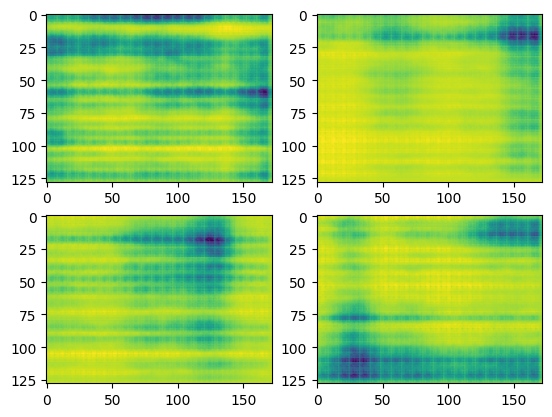

In [3]:
import matplotlib.pyplot as plt
import torch
from VAE_models import load_vae_model
conv = True
model, checkpoint = load_vae_model('./models/conv_vae/c_vae_checkpoint_20250731-142256.pt', 'cuda', conv=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()

z = torch.randn(4, checkpoint['config']['latent_dim']).to(device)
with torch.no_grad():
    samples = model.decode(z)
samples = samples.cpu().view(4, 128, 172).numpy()
plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(samples[i])

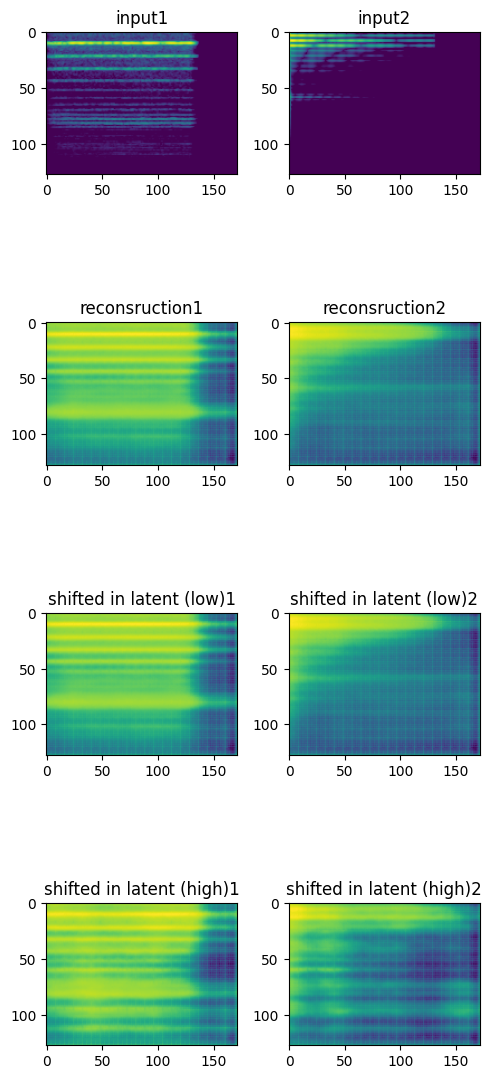

In [4]:
from datasets import HDF5SpectrogramDataset
from torch.utils.data import DataLoader
import numpy as np
num_samples = 2
train_data = HDF5SpectrogramDataset(project_root / 'data' / 'train_spectrograms_even.h5')
train_loader = DataLoader(train_data, batch_size=num_samples, shuffle=True)

inputs = next(iter(train_loader))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inputs = inputs.to(device)
with torch.no_grad():
    if not conv:
        inputs = inputs.view(num_samples, -1)  # Flatten the data when not using convolutional VAE
    else:
        inputs = inputs.view(num_samples, 1, 128, 172)
    dist = model.encode(inputs)
    z_s = model.reparameterize(dist)
    recons = model.decode(z_s).cpu().view(num_samples, 128, 172).numpy()
    shifted_z_s_high = z_s + torch.rand_like(z_s) * 5.0
    shifted_z_s_low = z_s + torch.rand_like(z_s) * 000.1
    shifted_high = model.decode(shifted_z_s_high).cpu().view(num_samples, 128, 172).numpy()
    shifted_low = model.decode(shifted_z_s_low).cpu().view(num_samples, 128, 172).numpy()
    inputs = inputs.cpu().view(num_samples, 128, 172).numpy()
images = np.array([inputs, recons, shifted_high, shifted_low]).reshape((8, 128, 172))
plt.figure(figsize=[5,12])
for i in range(num_samples):
    plt.subplot(4,num_samples,i+1)
    plt.imshow(inputs[i])
    plt.title(f'input{i+1}')
    plt.subplot(4,num_samples,i+num_samples+1)
    plt.imshow(recons[i])
    plt.title(f'reconsruction{i+1}')
    plt.subplot(4,num_samples,i+2*num_samples+1)
    plt.imshow(shifted_low[i])
    plt.title(f'shifted in latent (low){i+1}')
    plt.subplot(4,num_samples,i+3*num_samples+1)
    plt.imshow(shifted_high[i])
    plt.title(f'shifted in latent (high){i+1}')
plt.tight_layout()



In [ ]:
import pandas as pd
df = pd.